# Interpretability tutorial

In this tutorial we will go through several popular visualization techniques that help interpret deep learning networks.

We will cover:
1. Filter visualization
2. Feature/ activation visualization
3. CNN Layer Visualization
4. Gradient visualization with Guided backpropagation
5. Gradient Class Activation Maps (grad-CAM)


In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import matplotlib.pyplot as plt
import numpy as np 
import visualizations
from visualizations.src.misc_functions import *
from visualizations.src.guided_backprop import GuidedBackprop
from visualizations.src.cnn_layer_visualization import CNNLayerVisualization
from visualizations.src.gradcam import GradCam
from visualizations.src.deep_dream import DeepDream


## 1. Filter Visualization

https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e

https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb#scrollTo=uQI9jHcP6xfP

One of the first things you can visualize in your network - is your network filters, or weights.
Your convolutional kernels have weights which are updated during training, and can be visualized by calling the weight data inside your network.

Let's first load and print a pretrained network using pytorch.models:

In [32]:
# first load pretrained alxenet model
alexnet = models.alexnet(pretrained=True)
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

We can see that the network is made up of two sequential models - features, and classifier.

To visualize the convolutional weights, we need to access a convolutional layer in the features model.

This can be done in the following way:
```python 
weight_tensor = model.features[layer_num].weight.data
```
**Note that layer_num should correspond to a convolutional layer - otherwise there are no weights to be visualized.**

We will now define a few functions to help with plotting:

In [33]:
def plot_filters_single_channel(t):
    
    kernels_to_plot = 30
    channels_to_plot = 3
    #kernels depth * number of kernels
    nplots = channels_to_plot*kernels_to_plot
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(kernels_to_plot):
        for j in range(channels_to_plot):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()    

    
def plot_filters_multi_channel(t):
    
    kernels_to_plot = 60
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = kernels_to_plot // num_cols
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(kernels_to_plot):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.tight_layout()
    plt.show()
    


We next define our plot weights function, which first extracts the weights of a convolutional filter, and then passes into an appropriate image plotting function.

In [34]:
def plot_weights(model, layer_num, single_channel = True):
    #extracting the model features at the particular layer number
    layer = model.features[layer_num]
  
    #checking whether the layer is convolution layer or not 

    if isinstance(layer, nn.Conv2d):
        #getting the weight tensor data
        weight_tensor = model.features[layer_num].weight.data
    
        if single_channel:
            plot_filters_single_channel(weight_tensor)
        
        else:
            if weight_tensor.shape[1] == 3:
                plot_filters_multi_channel(weight_tensor)
            else:
                print("Can only plot weights with three channels with single channel = False")
        
    else:
        print("Can only visualize layers which are convolutional")
    

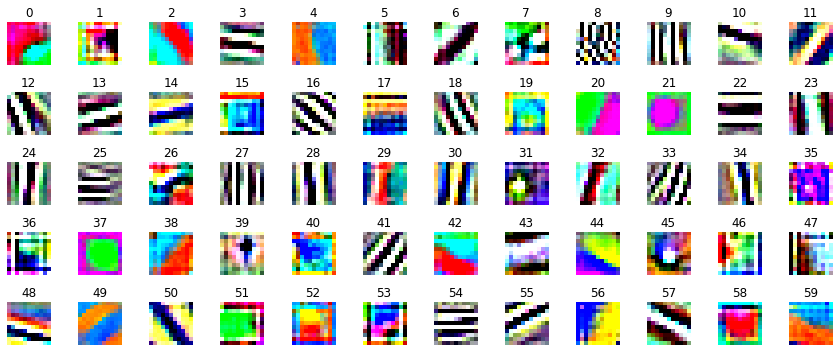

In [39]:
#visualize weights for alexnet - first conv layer
plot_weights(alexnet, 0, single_channel = False)


### Task 1: Visualize the filters of different convolutional layers

Use the plot_weights() function to visualize filters of different convolutional layers.

Note that you can plot single channels if you set single_channel=True (if the filters have 3 channels)


In [6]:
# --------------------------------------------- Task 1 --------------------------------------------------------
# write code here


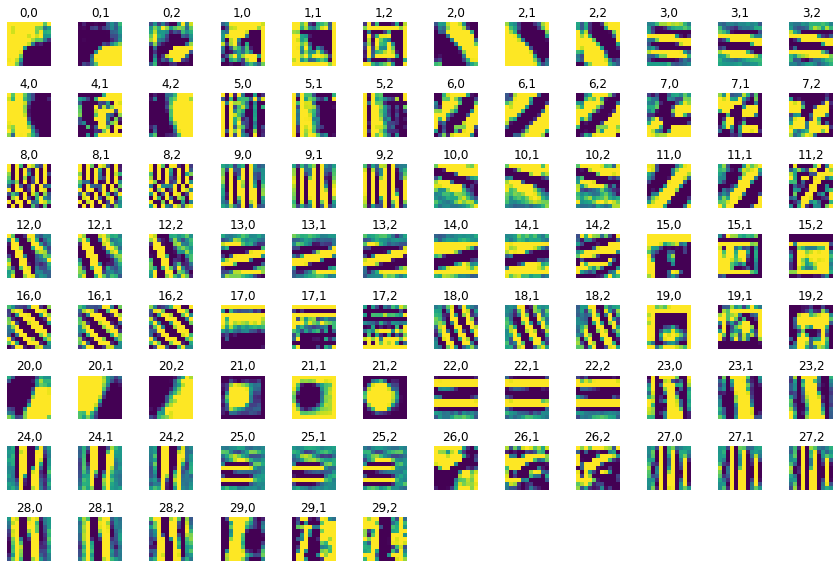

In [6]:
plot_weights(alexnet, 0, single_channel = True)

## 2. Activation visualization

Another effective approach to examine what your network is learning, is the visualize your network's features or activations, i.e. intermediate outputs of your network for a specific inputs.

In the following example, we set up a simple autoencoder network, a network that learns to reconstruct an input, using the MNIST dataset. 

https://discuss.pytorch.org/t/visualize-feature-map/29597/2

### Set up and train a simple autoencoder
We first set up the network, dataset (MNIST using torchvision), optimizer, and loss function. 

In [40]:
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 3, 3, 1, 1)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(3, 6, 3, 1, 1)
        self.pool2 = nn.MaxPool2d(2)
        
        self.conv_trans1 = nn.ConvTranspose2d(6, 3, 4, 2, 1)
        self.conv_trans2 = nn.ConvTranspose2d(3, 1, 4, 2, 1)
        
    def forward(self, x):
        x = F.relu(self.pool1(self.conv1(x)))
        x = F.relu(self.pool2(self.conv2(x)))        
        x = F.relu(self.conv_trans1(x))
        x = self.conv_trans2(x)
        return x

# normalisation - for plotting output
def min_max_norm(img):
    img = img - img.min()
    img = img / img.max()
    return img

dataset = datasets.MNIST(
    root="data",download=True,
    transform=transforms.ToTensor()
)
loader = DataLoader(
    dataset,
    num_workers=2,
    batch_size=8,
    shuffle=True
)

# initialize the network, loss function and optimizer 
model = SimpleAutoencoder()
criterion_l1 = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)


Train our simple network on MNIST

In [41]:
epochs = 1
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion_l1(output, data)
        loss.backward()
        optimizer.step()
        
        print('Epoch {}, Iteration {}, loss {}'.format(
            epoch, batch_idx, loss.item()))


Epoch 0, Iteration 0, loss 0.7263402938842773
Epoch 0, Iteration 1, loss 0.7239919900894165
Epoch 0, Iteration 2, loss 0.7233205437660217
Epoch 0, Iteration 3, loss 0.7230895757675171
Epoch 0, Iteration 4, loss 0.7217974662780762
Epoch 0, Iteration 5, loss 0.7209873795509338
Epoch 0, Iteration 6, loss 0.7212455868721008
Epoch 0, Iteration 7, loss 0.7191687822341919
Epoch 0, Iteration 8, loss 0.7184361219406128
Epoch 0, Iteration 9, loss 0.7186221480369568
Epoch 0, Iteration 10, loss 0.7148278951644897
Epoch 0, Iteration 11, loss 0.7145645618438721
Epoch 0, Iteration 12, loss 0.714149534702301
Epoch 0, Iteration 13, loss 0.7125681638717651
Epoch 0, Iteration 14, loss 0.7117876410484314
Epoch 0, Iteration 15, loss 0.7126274108886719
Epoch 0, Iteration 16, loss 0.7096354961395264
Epoch 0, Iteration 17, loss 0.7081776857376099
Epoch 0, Iteration 18, loss 0.7090201377868652
Epoch 0, Iteration 19, loss 0.707030177116394
Epoch 0, Iteration 20, loss 0.7063573002815247
Epoch 0, Iteration 21, lo

Epoch 0, Iteration 340, loss 0.14206671714782715
Epoch 0, Iteration 341, loss 0.1922803372144699
Epoch 0, Iteration 342, loss 0.17618216574192047
Epoch 0, Iteration 343, loss 0.1854611188173294
Epoch 0, Iteration 344, loss 0.182667076587677
Epoch 0, Iteration 345, loss 0.17366144061088562
Epoch 0, Iteration 346, loss 0.17146065831184387
Epoch 0, Iteration 347, loss 0.15576545894145966
Epoch 0, Iteration 348, loss 0.19020456075668335
Epoch 0, Iteration 349, loss 0.1665288358926773
Epoch 0, Iteration 350, loss 0.1913241297006607
Epoch 0, Iteration 351, loss 0.15609200298786163
Epoch 0, Iteration 352, loss 0.16918577253818512
Epoch 0, Iteration 353, loss 0.18142536282539368
Epoch 0, Iteration 354, loss 0.17857347428798676
Epoch 0, Iteration 355, loss 0.1749950498342514
Epoch 0, Iteration 356, loss 0.1548646092414856
Epoch 0, Iteration 357, loss 0.17891553044319153
Epoch 0, Iteration 358, loss 0.16565388441085815
Epoch 0, Iteration 359, loss 0.2291025072336197
Epoch 0, Iteration 360, loss 

Epoch 0, Iteration 676, loss 0.1458231657743454
Epoch 0, Iteration 677, loss 0.15304209291934967
Epoch 0, Iteration 678, loss 0.15877722203731537
Epoch 0, Iteration 679, loss 0.13832664489746094
Epoch 0, Iteration 680, loss 0.15242813527584076
Epoch 0, Iteration 681, loss 0.15516845881938934
Epoch 0, Iteration 682, loss 0.1545756608247757
Epoch 0, Iteration 683, loss 0.17442366480827332
Epoch 0, Iteration 684, loss 0.15850888192653656
Epoch 0, Iteration 685, loss 0.1604987233877182
Epoch 0, Iteration 686, loss 0.15299826860427856
Epoch 0, Iteration 687, loss 0.1515156775712967
Epoch 0, Iteration 688, loss 0.15744146704673767
Epoch 0, Iteration 689, loss 0.17644506692886353
Epoch 0, Iteration 690, loss 0.1493888944387436
Epoch 0, Iteration 691, loss 0.12841112911701202
Epoch 0, Iteration 692, loss 0.16289855539798737
Epoch 0, Iteration 693, loss 0.14961858093738556
Epoch 0, Iteration 694, loss 0.1604360193014145
Epoch 0, Iteration 695, loss 0.11188360303640366
Epoch 0, Iteration 696, lo

Epoch 0, Iteration 1011, loss 0.14723700284957886
Epoch 0, Iteration 1012, loss 0.13418611884117126
Epoch 0, Iteration 1013, loss 0.14125807583332062
Epoch 0, Iteration 1014, loss 0.1428794264793396
Epoch 0, Iteration 1015, loss 0.1464667171239853
Epoch 0, Iteration 1016, loss 0.11855380237102509
Epoch 0, Iteration 1017, loss 0.1413620412349701
Epoch 0, Iteration 1018, loss 0.11073789745569229
Epoch 0, Iteration 1019, loss 0.14609013497829437
Epoch 0, Iteration 1020, loss 0.15193922817707062
Epoch 0, Iteration 1021, loss 0.11276875436306
Epoch 0, Iteration 1022, loss 0.14730261266231537
Epoch 0, Iteration 1023, loss 0.12911665439605713
Epoch 0, Iteration 1024, loss 0.1369895488023758
Epoch 0, Iteration 1025, loss 0.11620079725980759
Epoch 0, Iteration 1026, loss 0.15206290781497955
Epoch 0, Iteration 1027, loss 0.13207267224788666
Epoch 0, Iteration 1028, loss 0.12836404144763947
Epoch 0, Iteration 1029, loss 0.135600745677948
Epoch 0, Iteration 1030, loss 0.12285925447940826
Epoch 0, 

Epoch 0, Iteration 1339, loss 0.13346073031425476
Epoch 0, Iteration 1340, loss 0.1191607192158699
Epoch 0, Iteration 1341, loss 0.12489815056324005
Epoch 0, Iteration 1342, loss 0.12996259331703186
Epoch 0, Iteration 1343, loss 0.11379329860210419
Epoch 0, Iteration 1344, loss 0.12125330418348312
Epoch 0, Iteration 1345, loss 0.12167387455701828
Epoch 0, Iteration 1346, loss 0.12704069912433624
Epoch 0, Iteration 1347, loss 0.1276230663061142
Epoch 0, Iteration 1348, loss 0.1586056798696518
Epoch 0, Iteration 1349, loss 0.1511894166469574
Epoch 0, Iteration 1350, loss 0.14838673174381256
Epoch 0, Iteration 1351, loss 0.11652716994285583
Epoch 0, Iteration 1352, loss 0.12095966190099716
Epoch 0, Iteration 1353, loss 0.11736451089382172
Epoch 0, Iteration 1354, loss 0.11830096691846848
Epoch 0, Iteration 1355, loss 0.14758607745170593
Epoch 0, Iteration 1356, loss 0.12943130731582642
Epoch 0, Iteration 1357, loss 0.12071823328733444
Epoch 0, Iteration 1358, loss 0.1353173553943634
Epoch

Epoch 0, Iteration 1667, loss 0.11252982169389725
Epoch 0, Iteration 1668, loss 0.1174248680472374
Epoch 0, Iteration 1669, loss 0.13906729221343994
Epoch 0, Iteration 1670, loss 0.12683677673339844
Epoch 0, Iteration 1671, loss 0.13510578870773315
Epoch 0, Iteration 1672, loss 0.10792963951826096
Epoch 0, Iteration 1673, loss 0.12949620187282562
Epoch 0, Iteration 1674, loss 0.14690998196601868
Epoch 0, Iteration 1675, loss 0.13057418167591095
Epoch 0, Iteration 1676, loss 0.10843910276889801
Epoch 0, Iteration 1677, loss 0.10557081550359726
Epoch 0, Iteration 1678, loss 0.12693338096141815
Epoch 0, Iteration 1679, loss 0.13776428997516632
Epoch 0, Iteration 1680, loss 0.11695289611816406
Epoch 0, Iteration 1681, loss 0.11369471997022629
Epoch 0, Iteration 1682, loss 0.12534792721271515
Epoch 0, Iteration 1683, loss 0.11268218606710434
Epoch 0, Iteration 1684, loss 0.11858995258808136
Epoch 0, Iteration 1685, loss 0.11493289470672607
Epoch 0, Iteration 1686, loss 0.12089227139949799
E

Epoch 0, Iteration 1995, loss 0.10994841158390045
Epoch 0, Iteration 1996, loss 0.10978326201438904
Epoch 0, Iteration 1997, loss 0.0978831946849823
Epoch 0, Iteration 1998, loss 0.09203840792179108
Epoch 0, Iteration 1999, loss 0.12003640830516815
Epoch 0, Iteration 2000, loss 0.10829716175794601
Epoch 0, Iteration 2001, loss 0.11996208876371384
Epoch 0, Iteration 2002, loss 0.09610631316900253
Epoch 0, Iteration 2003, loss 0.09656228870153427
Epoch 0, Iteration 2004, loss 0.1045985296368599
Epoch 0, Iteration 2005, loss 0.11832723766565323
Epoch 0, Iteration 2006, loss 0.11091701686382294
Epoch 0, Iteration 2007, loss 0.1086798682808876
Epoch 0, Iteration 2008, loss 0.11398254334926605
Epoch 0, Iteration 2009, loss 0.11192351579666138
Epoch 0, Iteration 2010, loss 0.09657144546508789
Epoch 0, Iteration 2011, loss 0.10806620121002197
Epoch 0, Iteration 2012, loss 0.1096569374203682
Epoch 0, Iteration 2013, loss 0.09959770739078522
Epoch 0, Iteration 2014, loss 0.11475079506635666
Epoc

Epoch 0, Iteration 2323, loss 0.11671103537082672
Epoch 0, Iteration 2324, loss 0.11169499903917313
Epoch 0, Iteration 2325, loss 0.10416338592767715
Epoch 0, Iteration 2326, loss 0.10548889636993408
Epoch 0, Iteration 2327, loss 0.11554381251335144
Epoch 0, Iteration 2328, loss 0.10199011862277985
Epoch 0, Iteration 2329, loss 0.10587549954652786
Epoch 0, Iteration 2330, loss 0.10083942115306854
Epoch 0, Iteration 2331, loss 0.11050685495138168
Epoch 0, Iteration 2332, loss 0.1070508286356926
Epoch 0, Iteration 2333, loss 0.09470564126968384
Epoch 0, Iteration 2334, loss 0.10314016789197922
Epoch 0, Iteration 2335, loss 0.09069997072219849
Epoch 0, Iteration 2336, loss 0.08331337571144104
Epoch 0, Iteration 2337, loss 0.11546347290277481
Epoch 0, Iteration 2338, loss 0.09628061205148697
Epoch 0, Iteration 2339, loss 0.09575454890727997
Epoch 0, Iteration 2340, loss 0.08573316037654877
Epoch 0, Iteration 2341, loss 0.09941515326499939
Epoch 0, Iteration 2342, loss 0.11006742715835571
E

Epoch 0, Iteration 2651, loss 0.10671402513980865
Epoch 0, Iteration 2652, loss 0.08891265094280243
Epoch 0, Iteration 2653, loss 0.10573946684598923
Epoch 0, Iteration 2654, loss 0.1085556373000145
Epoch 0, Iteration 2655, loss 0.08288322389125824
Epoch 0, Iteration 2656, loss 0.10158801823854446
Epoch 0, Iteration 2657, loss 0.11068089306354523
Epoch 0, Iteration 2658, loss 0.10686839371919632
Epoch 0, Iteration 2659, loss 0.10964209586381912
Epoch 0, Iteration 2660, loss 0.11768010258674622
Epoch 0, Iteration 2661, loss 0.10409336537122726
Epoch 0, Iteration 2662, loss 0.0822247564792633
Epoch 0, Iteration 2663, loss 0.10417459160089493
Epoch 0, Iteration 2664, loss 0.10293471813201904
Epoch 0, Iteration 2665, loss 0.104711152613163
Epoch 0, Iteration 2666, loss 0.0930292010307312
Epoch 0, Iteration 2667, loss 0.10770168900489807
Epoch 0, Iteration 2668, loss 0.10974397510290146
Epoch 0, Iteration 2669, loss 0.08513368666172028
Epoch 0, Iteration 2670, loss 0.10171827673912048
Epoch

Epoch 0, Iteration 2979, loss 0.10069993138313293
Epoch 0, Iteration 2980, loss 0.09647078067064285
Epoch 0, Iteration 2981, loss 0.10552193969488144
Epoch 0, Iteration 2982, loss 0.07820270210504532
Epoch 0, Iteration 2983, loss 0.08923476934432983
Epoch 0, Iteration 2984, loss 0.08282918483018875
Epoch 0, Iteration 2985, loss 0.09927942603826523
Epoch 0, Iteration 2986, loss 0.09081707894802094
Epoch 0, Iteration 2987, loss 0.10344136506319046
Epoch 0, Iteration 2988, loss 0.09478576481342316
Epoch 0, Iteration 2989, loss 0.08608138561248779
Epoch 0, Iteration 2990, loss 0.10428920388221741
Epoch 0, Iteration 2991, loss 0.0898687019944191
Epoch 0, Iteration 2992, loss 0.09425952285528183
Epoch 0, Iteration 2993, loss 0.09828650951385498
Epoch 0, Iteration 2994, loss 0.09232984483242035
Epoch 0, Iteration 2995, loss 0.10531918704509735
Epoch 0, Iteration 2996, loss 0.09646674245595932
Epoch 0, Iteration 2997, loss 0.10723209381103516
Epoch 0, Iteration 2998, loss 0.09697126597166061
E

Epoch 0, Iteration 3307, loss 0.10043033212423325
Epoch 0, Iteration 3308, loss 0.10316145420074463
Epoch 0, Iteration 3309, loss 0.09844928234815598
Epoch 0, Iteration 3310, loss 0.08584673702716827
Epoch 0, Iteration 3311, loss 0.09983948618173599
Epoch 0, Iteration 3312, loss 0.09078757464885712
Epoch 0, Iteration 3313, loss 0.09811713546514511
Epoch 0, Iteration 3314, loss 0.09340720623731613
Epoch 0, Iteration 3315, loss 0.0980195626616478
Epoch 0, Iteration 3316, loss 0.09474828094244003
Epoch 0, Iteration 3317, loss 0.09612865746021271
Epoch 0, Iteration 3318, loss 0.08163245767354965
Epoch 0, Iteration 3319, loss 0.08926092088222504
Epoch 0, Iteration 3320, loss 0.09651768207550049
Epoch 0, Iteration 3321, loss 0.0981278344988823
Epoch 0, Iteration 3322, loss 0.10462868958711624
Epoch 0, Iteration 3323, loss 0.10212716460227966
Epoch 0, Iteration 3324, loss 0.09148178994655609
Epoch 0, Iteration 3325, loss 0.09101703017950058
Epoch 0, Iteration 3326, loss 0.08656322956085205
Ep

Epoch 0, Iteration 3635, loss 0.0899195596575737
Epoch 0, Iteration 3636, loss 0.08239240199327469
Epoch 0, Iteration 3637, loss 0.08663997799158096
Epoch 0, Iteration 3638, loss 0.07845938950777054
Epoch 0, Iteration 3639, loss 0.10027744621038437
Epoch 0, Iteration 3640, loss 0.1024889349937439
Epoch 0, Iteration 3641, loss 0.08814436942338943
Epoch 0, Iteration 3642, loss 0.09039264917373657
Epoch 0, Iteration 3643, loss 0.08715225756168365
Epoch 0, Iteration 3644, loss 0.10077682882547379
Epoch 0, Iteration 3645, loss 0.09657370299100876
Epoch 0, Iteration 3646, loss 0.09469527006149292
Epoch 0, Iteration 3647, loss 0.07269307971000671
Epoch 0, Iteration 3648, loss 0.09796463698148727
Epoch 0, Iteration 3649, loss 0.10885097831487656
Epoch 0, Iteration 3650, loss 0.09965914487838745
Epoch 0, Iteration 3651, loss 0.07231413573026657
Epoch 0, Iteration 3652, loss 0.09040120244026184
Epoch 0, Iteration 3653, loss 0.09133321046829224
Epoch 0, Iteration 3654, loss 0.11364708840847015
Ep

Epoch 0, Iteration 3963, loss 0.1021018773317337
Epoch 0, Iteration 3964, loss 0.07442160695791245
Epoch 0, Iteration 3965, loss 0.08305952697992325
Epoch 0, Iteration 3966, loss 0.09002697467803955
Epoch 0, Iteration 3967, loss 0.08156099915504456
Epoch 0, Iteration 3968, loss 0.09331649541854858
Epoch 0, Iteration 3969, loss 0.08674449473619461
Epoch 0, Iteration 3970, loss 0.09609369188547134
Epoch 0, Iteration 3971, loss 0.07334179431200027
Epoch 0, Iteration 3972, loss 0.09703109413385391
Epoch 0, Iteration 3973, loss 0.08408178389072418
Epoch 0, Iteration 3974, loss 0.09599306434392929
Epoch 0, Iteration 3975, loss 0.09009253978729248
Epoch 0, Iteration 3976, loss 0.09275860339403152
Epoch 0, Iteration 3977, loss 0.09321187436580658
Epoch 0, Iteration 3978, loss 0.10560369491577148
Epoch 0, Iteration 3979, loss 0.0871037170290947
Epoch 0, Iteration 3980, loss 0.07724463939666748
Epoch 0, Iteration 3981, loss 0.08990372717380524
Epoch 0, Iteration 3982, loss 0.09694795310497284
Ep

Epoch 0, Iteration 4291, loss 0.09711258113384247
Epoch 0, Iteration 4292, loss 0.10888111591339111
Epoch 0, Iteration 4293, loss 0.08959124237298965
Epoch 0, Iteration 4294, loss 0.09159224480390549
Epoch 0, Iteration 4295, loss 0.10434073209762573
Epoch 0, Iteration 4296, loss 0.09228023141622543
Epoch 0, Iteration 4297, loss 0.07905177772045135
Epoch 0, Iteration 4298, loss 0.09709864854812622
Epoch 0, Iteration 4299, loss 0.08999858796596527
Epoch 0, Iteration 4300, loss 0.09606115520000458
Epoch 0, Iteration 4301, loss 0.07123790681362152
Epoch 0, Iteration 4302, loss 0.07939142733812332
Epoch 0, Iteration 4303, loss 0.08087235689163208
Epoch 0, Iteration 4304, loss 0.0811387374997139
Epoch 0, Iteration 4305, loss 0.09017938375473022
Epoch 0, Iteration 4306, loss 0.08999032527208328
Epoch 0, Iteration 4307, loss 0.07704568654298782
Epoch 0, Iteration 4308, loss 0.08946771174669266
Epoch 0, Iteration 4309, loss 0.07818040251731873
Epoch 0, Iteration 4310, loss 0.09624859690666199
E

Epoch 0, Iteration 4619, loss 0.0914275124669075
Epoch 0, Iteration 4620, loss 0.08399517834186554
Epoch 0, Iteration 4621, loss 0.08515959233045578
Epoch 0, Iteration 4622, loss 0.08826237916946411
Epoch 0, Iteration 4623, loss 0.08763815462589264
Epoch 0, Iteration 4624, loss 0.09207171946763992
Epoch 0, Iteration 4625, loss 0.07208351045846939
Epoch 0, Iteration 4626, loss 0.09933490306138992
Epoch 0, Iteration 4627, loss 0.08447309583425522
Epoch 0, Iteration 4628, loss 0.09354817867279053
Epoch 0, Iteration 4629, loss 0.09220725297927856
Epoch 0, Iteration 4630, loss 0.09009053558111191
Epoch 0, Iteration 4631, loss 0.11538881063461304
Epoch 0, Iteration 4632, loss 0.09099646657705307
Epoch 0, Iteration 4633, loss 0.07839740812778473
Epoch 0, Iteration 4634, loss 0.08422061055898666
Epoch 0, Iteration 4635, loss 0.09469177573919296
Epoch 0, Iteration 4636, loss 0.1066976860165596
Epoch 0, Iteration 4637, loss 0.09371428936719894
Epoch 0, Iteration 4638, loss 0.08947578072547913
Ep

Epoch 0, Iteration 4947, loss 0.07873708754777908
Epoch 0, Iteration 4948, loss 0.10237163305282593
Epoch 0, Iteration 4949, loss 0.08317635953426361
Epoch 0, Iteration 4950, loss 0.08081987500190735
Epoch 0, Iteration 4951, loss 0.09760021418333054
Epoch 0, Iteration 4952, loss 0.08671744912862778
Epoch 0, Iteration 4953, loss 0.08458393812179565
Epoch 0, Iteration 4954, loss 0.09317805618047714
Epoch 0, Iteration 4955, loss 0.09570684283971786
Epoch 0, Iteration 4956, loss 0.08843512088060379
Epoch 0, Iteration 4957, loss 0.08983004838228226
Epoch 0, Iteration 4958, loss 0.09244482219219208
Epoch 0, Iteration 4959, loss 0.09068682789802551
Epoch 0, Iteration 4960, loss 0.07659585028886795
Epoch 0, Iteration 4961, loss 0.09696286916732788
Epoch 0, Iteration 4962, loss 0.0967019721865654
Epoch 0, Iteration 4963, loss 0.10101795196533203
Epoch 0, Iteration 4964, loss 0.08269622176885605
Epoch 0, Iteration 4965, loss 0.09109511971473694
Epoch 0, Iteration 4966, loss 0.10086532682180405
E

Epoch 0, Iteration 5275, loss 0.10035724192857742
Epoch 0, Iteration 5276, loss 0.09351527690887451
Epoch 0, Iteration 5277, loss 0.0828276053071022
Epoch 0, Iteration 5278, loss 0.08503837138414383
Epoch 0, Iteration 5279, loss 0.07658717781305313
Epoch 0, Iteration 5280, loss 0.09496616572141647
Epoch 0, Iteration 5281, loss 0.08494025468826294
Epoch 0, Iteration 5282, loss 0.08282443135976791
Epoch 0, Iteration 5283, loss 0.09220059961080551
Epoch 0, Iteration 5284, loss 0.09397260844707489
Epoch 0, Iteration 5285, loss 0.08896668255329132
Epoch 0, Iteration 5286, loss 0.07387471944093704
Epoch 0, Iteration 5287, loss 0.0800965204834938
Epoch 0, Iteration 5288, loss 0.07397674769163132
Epoch 0, Iteration 5289, loss 0.10947989672422409
Epoch 0, Iteration 5290, loss 0.07976694405078888
Epoch 0, Iteration 5291, loss 0.08885885775089264
Epoch 0, Iteration 5292, loss 0.08515522629022598
Epoch 0, Iteration 5293, loss 0.08517981320619583
Epoch 0, Iteration 5294, loss 0.10416717827320099
Ep

Epoch 0, Iteration 5603, loss 0.0799102708697319
Epoch 0, Iteration 5604, loss 0.08635710924863815
Epoch 0, Iteration 5605, loss 0.08397858589887619
Epoch 0, Iteration 5606, loss 0.10487749427556992
Epoch 0, Iteration 5607, loss 0.0814392939209938
Epoch 0, Iteration 5608, loss 0.10316271334886551
Epoch 0, Iteration 5609, loss 0.07979811728000641
Epoch 0, Iteration 5610, loss 0.09766608476638794
Epoch 0, Iteration 5611, loss 0.07780945301055908
Epoch 0, Iteration 5612, loss 0.07523243129253387
Epoch 0, Iteration 5613, loss 0.0783466175198555
Epoch 0, Iteration 5614, loss 0.08945231884717941
Epoch 0, Iteration 5615, loss 0.08079683780670166
Epoch 0, Iteration 5616, loss 0.09675747901201248
Epoch 0, Iteration 5617, loss 0.08475001156330109
Epoch 0, Iteration 5618, loss 0.09118111431598663
Epoch 0, Iteration 5619, loss 0.08801422268152237
Epoch 0, Iteration 5620, loss 0.09609310328960419
Epoch 0, Iteration 5621, loss 0.08236061781644821
Epoch 0, Iteration 5622, loss 0.08406739681959152
Epo

Epoch 0, Iteration 5931, loss 0.07075195759534836
Epoch 0, Iteration 5932, loss 0.0861499160528183
Epoch 0, Iteration 5933, loss 0.0954553633928299
Epoch 0, Iteration 5934, loss 0.07844264060258865
Epoch 0, Iteration 5935, loss 0.08444181084632874
Epoch 0, Iteration 5936, loss 0.09601615369319916
Epoch 0, Iteration 5937, loss 0.10633774101734161
Epoch 0, Iteration 5938, loss 0.0789891928434372
Epoch 0, Iteration 5939, loss 0.09938649088144302
Epoch 0, Iteration 5940, loss 0.09046176820993423
Epoch 0, Iteration 5941, loss 0.07856112718582153
Epoch 0, Iteration 5942, loss 0.08040490746498108
Epoch 0, Iteration 5943, loss 0.077998086810112
Epoch 0, Iteration 5944, loss 0.10437799990177155
Epoch 0, Iteration 5945, loss 0.08613568544387817
Epoch 0, Iteration 5946, loss 0.08565590530633926
Epoch 0, Iteration 5947, loss 0.08224008232355118
Epoch 0, Iteration 5948, loss 0.07399021834135056
Epoch 0, Iteration 5949, loss 0.07442989945411682
Epoch 0, Iteration 5950, loss 0.09074939787387848
Epoch

Epoch 0, Iteration 6259, loss 0.10307640582323074
Epoch 0, Iteration 6260, loss 0.07314328104257584
Epoch 0, Iteration 6261, loss 0.0775674432516098
Epoch 0, Iteration 6262, loss 0.09748532623052597
Epoch 0, Iteration 6263, loss 0.08461184054613113
Epoch 0, Iteration 6264, loss 0.07979689538478851
Epoch 0, Iteration 6265, loss 0.08160663396120071
Epoch 0, Iteration 6266, loss 0.0910709947347641
Epoch 0, Iteration 6267, loss 0.09525884687900543
Epoch 0, Iteration 6268, loss 0.081475168466568
Epoch 0, Iteration 6269, loss 0.07202808558940887
Epoch 0, Iteration 6270, loss 0.08146502077579498
Epoch 0, Iteration 6271, loss 0.07755836099386215
Epoch 0, Iteration 6272, loss 0.10150516033172607
Epoch 0, Iteration 6273, loss 0.08924288302659988
Epoch 0, Iteration 6274, loss 0.08373132348060608
Epoch 0, Iteration 6275, loss 0.0852222815155983
Epoch 0, Iteration 6276, loss 0.08438926935195923
Epoch 0, Iteration 6277, loss 0.08406876772642136
Epoch 0, Iteration 6278, loss 0.09784873574972153
Epoch

Epoch 0, Iteration 6587, loss 0.0783303827047348
Epoch 0, Iteration 6588, loss 0.09148060530424118
Epoch 0, Iteration 6589, loss 0.0820871889591217
Epoch 0, Iteration 6590, loss 0.08403715491294861
Epoch 0, Iteration 6591, loss 0.08573661744594574
Epoch 0, Iteration 6592, loss 0.08837893605232239
Epoch 0, Iteration 6593, loss 0.08743028342723846
Epoch 0, Iteration 6594, loss 0.09362205862998962
Epoch 0, Iteration 6595, loss 0.08321386575698853
Epoch 0, Iteration 6596, loss 0.09742441028356552
Epoch 0, Iteration 6597, loss 0.0944361686706543
Epoch 0, Iteration 6598, loss 0.09335591644048691
Epoch 0, Iteration 6599, loss 0.09291956573724747
Epoch 0, Iteration 6600, loss 0.09469835460186005
Epoch 0, Iteration 6601, loss 0.07810316979885101
Epoch 0, Iteration 6602, loss 0.10213509202003479
Epoch 0, Iteration 6603, loss 0.0828407034277916
Epoch 0, Iteration 6604, loss 0.08575546741485596
Epoch 0, Iteration 6605, loss 0.07903419435024261
Epoch 0, Iteration 6606, loss 0.08290646970272064
Epoc

Epoch 0, Iteration 6915, loss 0.08871489763259888
Epoch 0, Iteration 6916, loss 0.07366681843996048
Epoch 0, Iteration 6917, loss 0.08732898533344269
Epoch 0, Iteration 6918, loss 0.08854757994413376
Epoch 0, Iteration 6919, loss 0.08500887453556061
Epoch 0, Iteration 6920, loss 0.0946860983967781
Epoch 0, Iteration 6921, loss 0.08886788040399551
Epoch 0, Iteration 6922, loss 0.10299470275640488
Epoch 0, Iteration 6923, loss 0.08554036915302277
Epoch 0, Iteration 6924, loss 0.08882342278957367
Epoch 0, Iteration 6925, loss 0.08395840972661972
Epoch 0, Iteration 6926, loss 0.09676043689250946
Epoch 0, Iteration 6927, loss 0.07705263048410416
Epoch 0, Iteration 6928, loss 0.08180417865514755
Epoch 0, Iteration 6929, loss 0.075172558426857
Epoch 0, Iteration 6930, loss 0.09388417750597
Epoch 0, Iteration 6931, loss 0.09327764064073563
Epoch 0, Iteration 6932, loss 0.08021719008684158
Epoch 0, Iteration 6933, loss 0.08261018246412277
Epoch 0, Iteration 6934, loss 0.09011336416006088
Epoch 

Epoch 0, Iteration 7243, loss 0.06982716917991638
Epoch 0, Iteration 7244, loss 0.08919443190097809
Epoch 0, Iteration 7245, loss 0.09368709474802017
Epoch 0, Iteration 7246, loss 0.07761358469724655
Epoch 0, Iteration 7247, loss 0.08912432938814163
Epoch 0, Iteration 7248, loss 0.088516466319561
Epoch 0, Iteration 7249, loss 0.08839339762926102
Epoch 0, Iteration 7250, loss 0.07823022454977036
Epoch 0, Iteration 7251, loss 0.08695002645254135
Epoch 0, Iteration 7252, loss 0.08874361217021942
Epoch 0, Iteration 7253, loss 0.08324030786752701
Epoch 0, Iteration 7254, loss 0.09315285086631775
Epoch 0, Iteration 7255, loss 0.09126592427492142
Epoch 0, Iteration 7256, loss 0.07798305153846741
Epoch 0, Iteration 7257, loss 0.09738273918628693
Epoch 0, Iteration 7258, loss 0.08324785530567169
Epoch 0, Iteration 7259, loss 0.0894065573811531
Epoch 0, Iteration 7260, loss 0.0853986069560051
Epoch 0, Iteration 7261, loss 0.08197027444839478
Epoch 0, Iteration 7262, loss 0.09951236099004745
Epoc

We now plot the result of our training - i.e. the real image, with the reconstructed image:

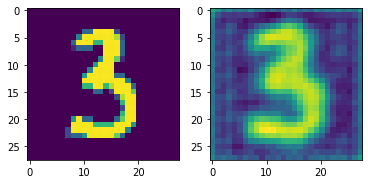

In [42]:
# Plot the input and output (i.e. reconstructed image)
idx = torch.randint(0, output.size(0), ())
pred = min_max_norm(output[idx, 0])
img = data[idx, 0]

fig, axarr = plt.subplots(1, 2)
axarr[0].imshow(img.detach().numpy())
axarr[1].imshow(pred.detach().numpy())


### Register hood to get network activations for a given input
We now need to register a forward hook on the model.

The hook will be called every time after forward() has computed an output. 
So the activation with the name specified will be saved after passing the data through the trained model.

You can register the hook in the following way:
```python
model.conv_name.register_forward_hook(get_activation('conv_name'))
```

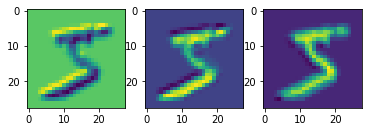

In [45]:
# Set up the hook for activations
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# Register the hook with the convolutional layer of interest
model.conv1.register_forward_hook(get_activation('conv1'))
data, _ = dataset[0]
data.unsqueeze_(0)

# Run through model again, to save the relavent activation
output = model(data)

# Visualize the activation
act = activation['conv1'].squeeze()
fig, axarr = plt.subplots(1, act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])


### Task 2: Visualise an activation of another convolutional layer
*Hint*: Look at the names for the layers when we first created our network

In [15]:
# --------------------------------------------- Task 2 --------------------------------------------------------
# write code here



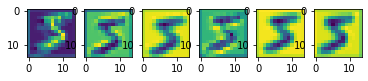

In [27]:
# Register the hook with the convolutional layer of interest
model.conv2.register_forward_hook(get_activation('conv2'))
data, _ = dataset[0]
data.unsqueeze_(0)

# Run through model again, to save the relavent activation
output = model(data)

# Visualize the activation
act = activation['conv2'].squeeze()
fig, axarr = plt.subplots(1, act.size(0))
for idx in range(act.size(0)):
    axarr[idx].imshow(act[idx])


## 3. CNN Layer Visualization

We will go through the next examples using code from the following repository https://github.com/utkuozbulak/pytorch-cnn-visualizations, which implements several well known visualization techniques for deep learning networks.

**CNN layer visualization** technique produces an image that minimizes the loss of a convolutional operation for a specific layer and filter - i.e. it learns the image that optimally activates a particular convolutional filter.

D. Erhan, Y. Bengio, A. Courville, P. Vincent. Visualizing Higher-Layer Features of a Deep Network https://www.researchgate.net/publication/265022827_Visualizing_Higher-Layer_Features_of_a_Deep_Network

**All the visualizations will be saved to** `/generated` folder

In [4]:
# load vgg model, and extract layers from the features modules only
pretrained_model = models.vgg16(pretrained=True).features


In [5]:
print(pretrained_model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [7]:
cnn_layer = 21
filter_pos = 5
# Fully connected layer is not needed
layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)

# Layer visualization with pytorch hooks
layer_vis.visualise_layer_with_hooks()

# Layer visualization without pytorch hooks
#layer_vis.visualise_layer_without_hooks()


Iteration: 1 Loss: 1.00
Iteration: 2 Loss: 0.54
Iteration: 3 Loss: -4.17
Iteration: 4 Loss: -7.75
Iteration: 5 Loss: -11.51
Iteration: 6 Loss: -14.92
Iteration: 7 Loss: -18.13
Iteration: 8 Loss: -21.20
Iteration: 9 Loss: -24.12
Iteration: 10 Loss: -26.99
Iteration: 11 Loss: -29.80
Iteration: 12 Loss: -32.58
Iteration: 13 Loss: -35.36
Iteration: 14 Loss: -38.08
Iteration: 15 Loss: -40.78
Iteration: 16 Loss: -43.45
Iteration: 17 Loss: -46.11
Iteration: 18 Loss: -48.76
Iteration: 19 Loss: -51.40
Iteration: 20 Loss: -54.00
Iteration: 21 Loss: -56.60
Iteration: 22 Loss: -59.23
Iteration: 23 Loss: -61.84
Iteration: 24 Loss: -64.49
Iteration: 25 Loss: -67.15
Iteration: 26 Loss: -69.82
Iteration: 27 Loss: -72.54
Iteration: 28 Loss: -75.27
Iteration: 29 Loss: -78.05
Iteration: 30 Loss: -80.81


### Task 3: Visualize different CNN layers and filters
Change the CNN layer and filter to visualize the network at different depths

In [ ]:
# --------------------------------------------- Task 3 --------------------------------------------------------
# write code here



## 4. Gradient visualization with Guided backpropagation

In order to visualise what is learnt by neurons in higher layers, a deconvolutional approach was developed, which inverts the data flow of a CNN, going from a neuron of interest to an image. The resulting image is the one which most strongly activates this neuron.

![guided_backprop](guided_backprop.png)

Details of the backprop method is in the following reference:

Springenberg, Jost Tobias, et al. "Striving for simplicity: The all convolutional net." arXiv preprint arXiv:1412.6806 (2014)-
https://arxiv.org/pdf/1412.6806.pdf

You can find the implementation of guided backpropagation in `/visualizations/src/guided_backprop.py`.

First get input image, class label, and pretrained model (pretrained alexnet):

In [5]:
target_example = 0  
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)


Then you create an instance of the guidedbackprop class using `GuidedBackprop(pretrained_model)`. 
This operation creates hooks on the model, which updates relu activation functions so that:
1. it stores the output of the forward pass
2. it imputes zero for gradient values that are less than zero, i.e. all gradients are clamped to zero


In [46]:
print(pretrained_model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [6]:
#--------------------------------------------------------- Guided backprop---------------------------------------------------
# Guided backprop
GBP = GuidedBackprop(pretrained_model)


 Then you can generate gradients that are specific to a particular input image, and class using the method `GP.generate_gradients()` with the following steps:
 1. go through a forward pass with the image input, and generate an output
 2. backprop through the output
 3. get the gradients from the backprop
 

In [7]:
# Get gradients
guided_grads = GBP.generate_gradients(prep_img, target_class)

Then we can save the gradients using the following plotting functions

In [8]:
#--------------------------------------------------------- Save images-------------------------------------------------------
# Save colored gradients
save_gradient_images(guided_grads, file_name_to_export + '_Guided_BP_color')
# Convert to grayscale
grayscale_guided_grads = convert_to_grayscale(guided_grads)
# Save grayscale gradients
save_gradient_images(grayscale_guided_grads, file_name_to_export + '_Guided_BP_gray')
# Positive and negative saliency maps
pos_sal, neg_sal = get_positive_negative_saliency(guided_grads)
save_gradient_images(pos_sal, file_name_to_export + '_pos_sal')
save_gradient_images(neg_sal, file_name_to_export + '_neg_sal')
print('Guided backprop completed')


Guided backprop completed


### Task 4: Run guided backprop for different inputs, and classes
You can do this by changing `target_example=` (there's 3 inputs available)


In [ ]:
# --------------------------------------------- Task 4 --------------------------------------------------------
# write code here


## 5. Gradient Class Activation Mapping (grad-CAM)


R. R. Selvaraju, A. Das, R. Vedantam, M. Cogswell, D. Parikh, and D. Batra. Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization, https://arxiv.org/abs/1610.02391

In [30]:
# Get params
target_example = 1
(original_image, prep_img, target_class, file_name_to_export, pretrained_model) =\
    get_example_params(target_example)

# Grad cam
grad_cam = GradCam(pretrained_model, target_layer=11)
# Generate cam mask
cam = grad_cam.generate_cam(prep_img, target_class)
# Save mask
save_class_activation_images(original_image, cam, file_name_to_export)
print('Grad cam completed')


Grad cam completed


## 6. Deep Dream


In [6]:
# THIS OPERATION IS MEMORY HUNGRY! #
# Because of the selected image is very large
# If it gives out of memory error or locks the computer
# Try it with a smaller image
cnn_layer = 34
filter_pos = 94

im_path = './visualizations/input_images/dd_tree.jpg'
# Fully connected layer is not needed

dd = DeepDream(pretrained_model, cnn_layer, filter_pos, im_path)
# This operation can also be done without Pytorch hooks
# See layer visualisation for the implementation without hooks
dd.dream()


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\cherb/.cache\torch\checkpoints\vgg19-dcbb9e9d.pth
100%|███████████████████████████████████████████████████████████████████████████████| 548M/548M [00:42<00:00, 13.5MB/s]


Iteration: 1 Loss: 2.77
Iteration: 2 Loss: 0.61
Iteration: 3 Loss: -1.57
Iteration: 4 Loss: -5.64
Iteration: 5 Loss: -10.87
Iteration: 6 Loss: -14.60
Iteration: 7 Loss: -19.93
Iteration: 8 Loss: -22.96
Iteration: 9 Loss: -26.42
Iteration: 10 Loss: -36.34
(117, 224, 3)
Iteration: 11 Loss: -44.76
Iteration: 12 Loss: -48.59
Iteration: 13 Loss: -61.83
Iteration: 14 Loss: -68.44
Iteration: 15 Loss: -86.76
Iteration: 16 Loss: -99.98
Iteration: 17 Loss: -108.20
Iteration: 18 Loss: -120.65
Iteration: 19 Loss: -130.63
Iteration: 20 Loss: -140.53
(117, 224, 3)
Iteration: 21 Loss: -161.21
Iteration: 22 Loss: -171.47
Iteration: 23 Loss: -184.46
Iteration: 24 Loss: -197.56
Iteration: 25 Loss: -205.05
Iteration: 26 Loss: -230.14
Iteration: 27 Loss: -250.46
Iteration: 28 Loss: -269.46
Iteration: 29 Loss: -280.43
Iteration: 30 Loss: -294.50
(117, 224, 3)
Iteration: 31 Loss: -307.95
Iteration: 32 Loss: -325.44
Iteration: 33 Loss: -340.58
Iteration: 34 Loss: -361.21
Iteration: 35 Loss: -379.82
Iteration